# Exercises

In [ ]:
# Imports
import pickle
from scipy.signal import butter
from scipy.signal import sosfilt
import matplotlib.pyplot as plt
from pywt import scale2frequency
from pywt import cwt
from pywt import wavelist
import numpy as np
import pickle
from scipy.signal import butter
from scipy.signal import sosfilt
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt

: 

In [ ]:
data_path = r"D:\Study\AI - Neuro-Analysis\Neuro-Analysis-Assignments\neural-data-master\neural-data-master\01-local_field_potential\data\moving_lfp.pickle"
with open(data_path, "rb") as f:
    moving_lfp_data = pickle.load(f)

lfp = moving_lfp_data['lfp']
sampling_rate = moving_lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

396 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
617 µs ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
867 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


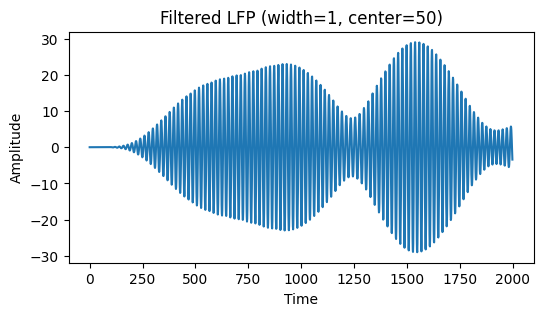

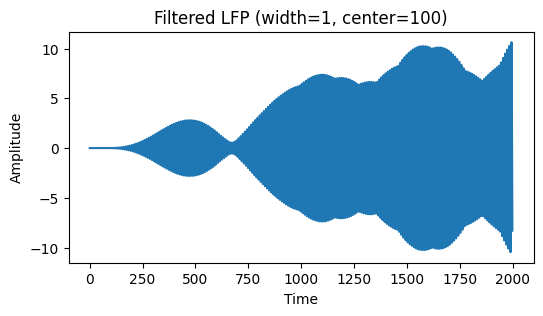

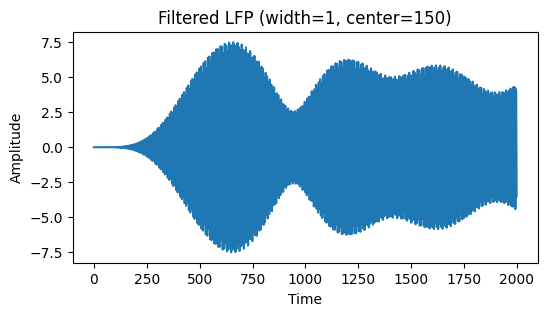

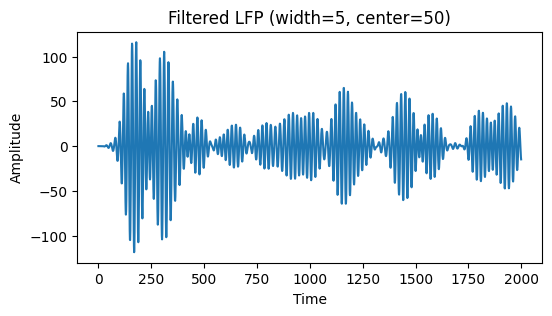

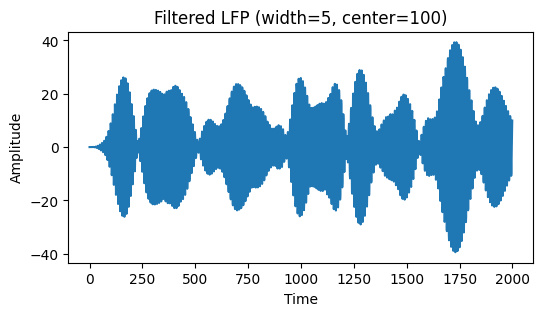

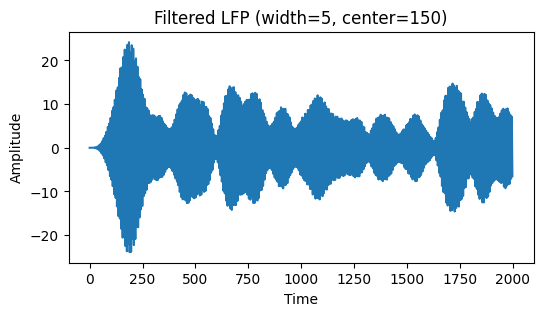

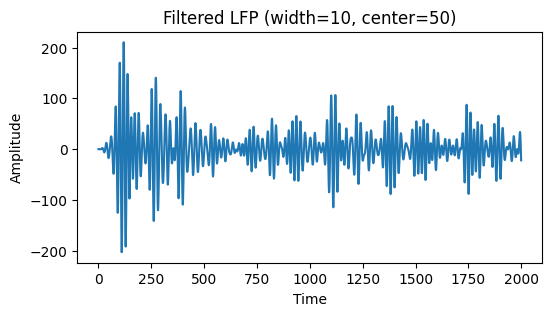

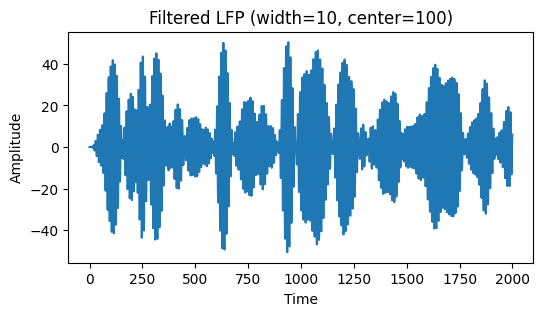

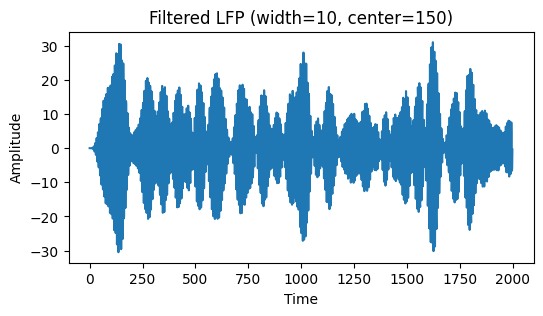

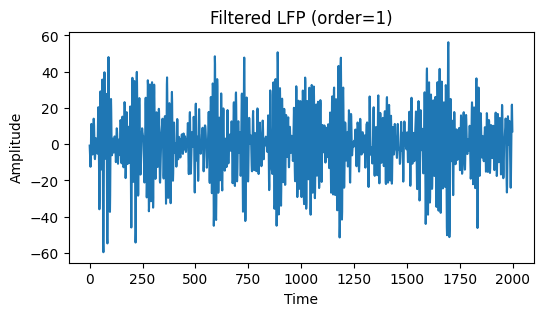

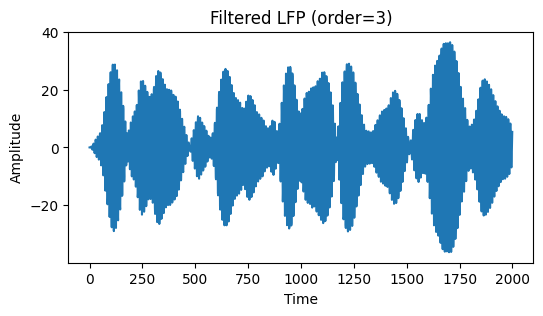

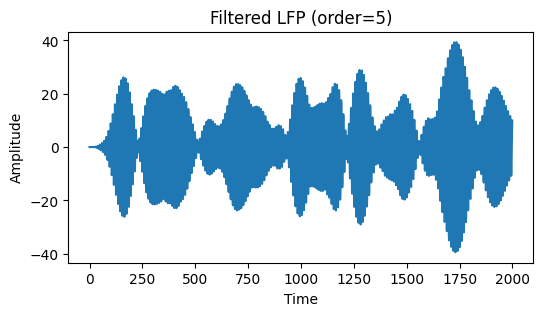

In [ ]:
def apply_filter(width, center, filter_order=5):
    filter = butter(filter_order,[center - width, center + width],
                    btype='band', 
                    output='sos', 
                    fs=sampling_rate)
    filtered_lfp = sosfilt(filter, lfp_segment)
    return filtered_lfp

duration = int(2 * sampling_rate)  # 2 seconds of data
start = 0
end = start + duration
lfp_segment = lfp[start:end]

for width in [1, 5, 10]:
    for center in [50, 100, 150]:
        filtered_lfp = apply_filter(width, center)
        plt.figure(figsize=(6, 3))
        plt.plot(filtered_lfp, label=f'width={width}, center={center}')
        plt.title(f'Filtered LFP (width={width}, center={center})')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

width = 5
center = 100
for order in [1, 3, 5]:
    %timeit apply_filter(width, center, filter_order=order)
    filtered_lfp = apply_filter(width, center, filter_order=order)
    plt.figure(figsize=(6, 3))
    plt.plot(filtered_lfp, label=f'order={order}')
    plt.title(f'Filtered LFP (order={order})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

**Comments**

So what can be observed is that increases in the width allow for more peaks and transients to be present in the output data. This makes sense since increasing the filter width allows a bigger frequency range to pass through, meaning higher complexity in the output data.
When it comes to the center we can observe that lower centers mainly pass through lower-end frequencies and higher centers mainly pass through higher frequencies, as seen in the plotted wavelengths. Another interesting observation is that centers of 150 seem to cause some amplitude modulation and frequency interference, especially for width = 1. I can't tell exactly why this would be happening, I might also be observing things that aren't there.

With regards to different filter orders, the higher the order, the steeper the filter, meaning that either highs or lows get cut off much more agressively. And this can be seen in the data as well. As the filter order increases the data becomes increasingly smooth. When the order is set to 1, the highs are not filtered as strongly, which would result in sharper peaks and less smooth curves, which we can also find in the plot. The effect on the low-end is not very clearly visible. What we can observe for the processing time is that higher order filters take almost linearly more processing time. 

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [ ]:
# Simply reuse the lfp_segment variable from exercise 1
sig = lfp_segment - np.mean(lfp_segment) # get rid of 0 frequency component
frequencies =  np.linspace(0.1,20,100)/sampling_rate

print(wavelist())

for wavelet in ["mexh", "gaus1", "morl"]:
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)
    plt.figure(figsize=(10,5))
    plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                            frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')
    plt.title(f'Wavelet transform (wavelet={wavelet})')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

**Comments**

My main observation is that the mexh and gaus wavelets have narrow centers at the top and long tails to higher frequencies in the spectrum plots. There are some small differences between mexh and gaus, but both plots follow roughly the same rules.
With the morl wavelet this is entirely different. It plots very localized, bright heat spots with very short and thin tails extending to the higher frequencies. What is very clearly observable is the waveshape the centers of the bulbs follow. This is also present in the other two wavelets but far less pronounced. 
I think these observations can be explained by the purpose of the Morlet versus the Guassian and Mexican Hat. The Morlet is used for optimal frequency resolution at the expense of frequency localization, whereas the other two yield more accurate frequency locations at the cost of poorer frequency localization. This exactly describes the observations in the output frequency spectra. 
In more detail: the Gaussian and Mexican Hat are higher order derivatives of each other and the main function $e^{−t^2 / (2/sigma^2)}$.
Morlet is an adaptation of this base wavelet function $e^{−t^2 / (2/sigma^2)}$ where a complex sinusoid and $C$ constants are added, which increases accuracy but then distorts the frequency precision of the base wavelet function. 

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [ ]:
data_path = r"D:\Study\AI - Neuro-Analysis\Neuro-Analysis-Assignments\neural-data-master\neural-data-master\01-local_field_potential\data\moving_lfp.pickle"
with open(data_path, "rb") as f:
    moving_lfp_data = pickle.load(f)

lfp = moving_lfp_data['lfp']
sampling_rate = moving_lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [ ]:
def apply_filter(signal, range, filter_order=5):
    filter = butter(filter_order, range,
                    btype='band', 
                    output='sos', 
                    fs=sampling_rate)
    filtered_lfp = sosfilt(filter, signal)
    return filtered_lfp

def instantaneous_power(signal, sampling_rate, low_f, high_f):
    signal = signal - np.mean(signal)  # remove DC component

    frequencies = np.linspace(low_f, high_f, 50) / sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)
    
    power = np.mean(abs(cwtmatr)**2,axis=0)
    return power

def compute_power_difference(theta, delta):
    return theta - delta

def compute_rem(signal, threshold=0.2):
    rem = np.zeros_like(signal)
    rem[signal > threshold] = 1
    rem_signal = np.where(signal > threshold)[0]
    
    nrem = np.zeros_like(signal)
    nrem[signal < threshold] = 1
    nrem_signal = np.where(signal < threshold)[0]
    return rem, nrem, rem_signal, nrem_signal

def wideband_filter(signal, lowcut=1, highcut=200, fs=sampling_rate, order=5):
    filter = butter(order, [lowcut, highcut], btype='band', output='sos', fs=fs)
    return sosfilt(filter, signal)

In [51]:
def plot(signal, label, title):
    plt.figure(figsize=(15,5))
    plt.plot(signal, label=label)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

theta_z: [-1.38337629 -1.38332321 -1.38326825 ... -1.10410816 -1.10512053
 -1.11037601]
delta_z: [-0.41874051 -0.41865304 -0.41856332 ...  7.54541217  7.50955456
  7.49924371]


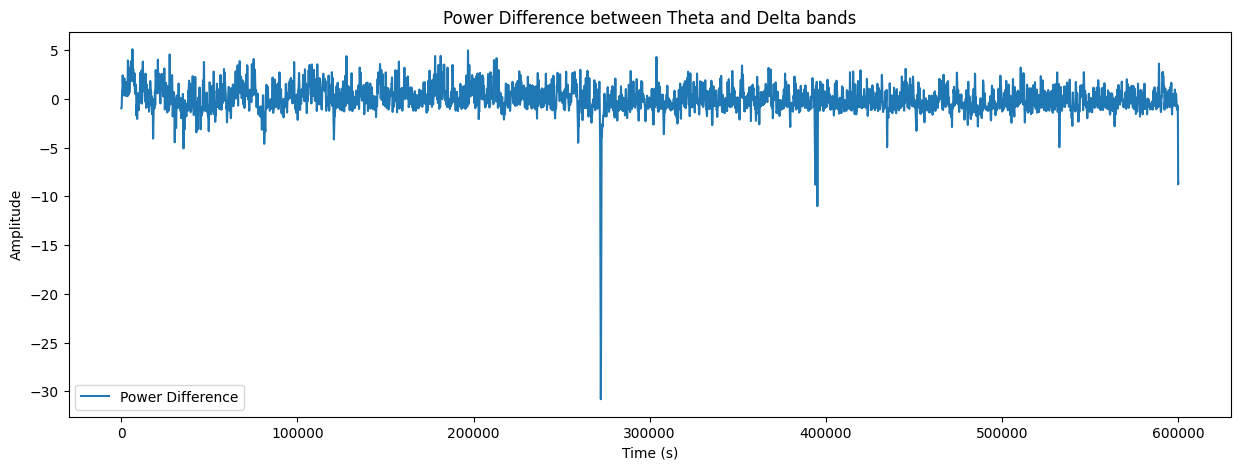

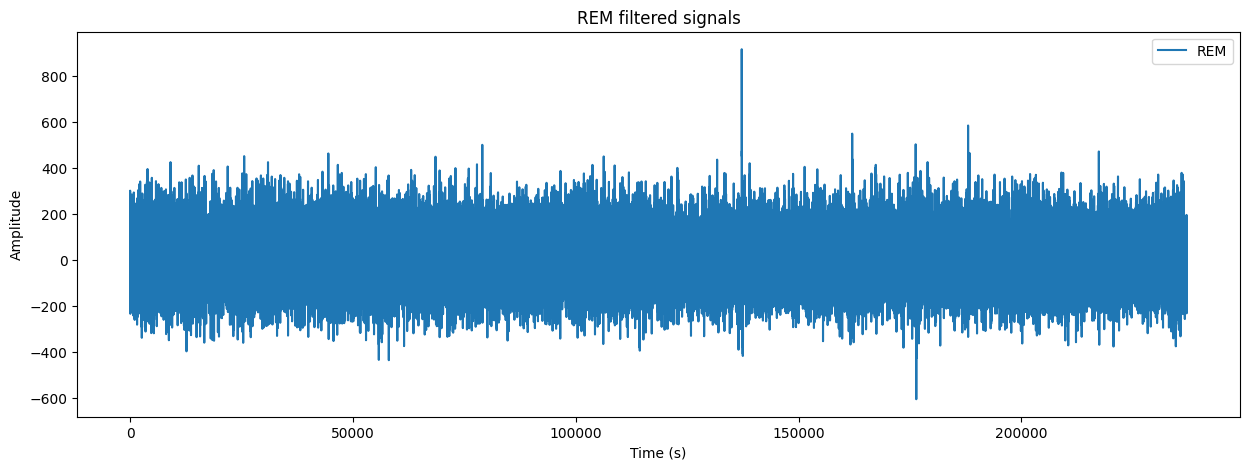

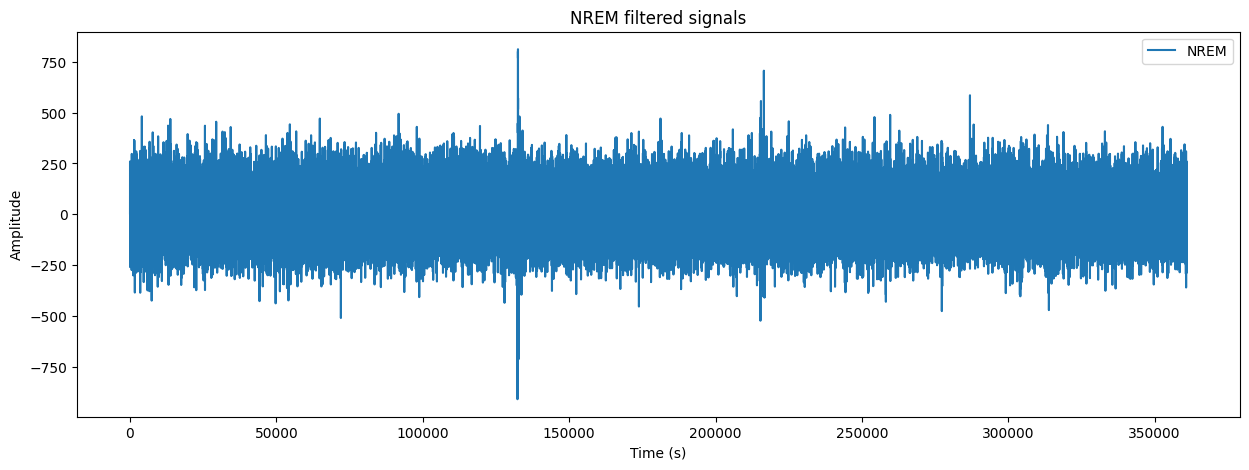

In [ ]:
rem_threshold = 0.2

theta_range = [6, 10]
delta_range = [2, 4]

theta_band = apply_filter(lfp, theta_range)
delta_band = apply_filter(lfp, delta_range)

theta_power = instantaneous_power(theta_band, sampling_rate, theta_range[0], theta_range[1])
delta_power = instantaneous_power(delta_band, sampling_rate, delta_range[0], delta_range[1])

theta_z = zscore(theta_power)
delta_z = zscore(delta_power)

print(f"theta_z: {theta_z}")
print(f"delta_z: {delta_z}")

power_difference = compute_power_difference(theta_z, delta_z)
plot(power_difference, 'Power Difference', 'Power Difference between Theta and Delta bands')

rem, nrem, rem_signal, nrem_signal = compute_rem(power_difference)
snippit_len = 1000
rem_lfp = lfp[rem == 1][snippit_len:]
nrem_lfp = lfp[nrem == 1][snippit_len:]
rem_filtered = wideband_filter(rem_lfp)
nrem_filtered = wideband_filter(nrem_lfp)

plot(rem_filtered, 'REM', 'REM filtered signals')
plot(nrem_filtered, 'NREM', 'NREM filtered signals')